<center>
    <h1>URBASPACE - SIGHT LINES</h1>
    <h2>Indicators</h2>
    <h3 style = 'color:#FF5733'>Compute sightline indicators</h3>        
</center>
<hr/>


In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import gc
import numpy as np
import time
import geopandas as gpd
import seaborn as sns
import rtree

from rtree import index as rtree_index
from shapely.geometry import Point,Polygon,MultiPoint,MultiLineString,LineString,box
from ipywidgets import HTML

# Configuration - Zone

In [2]:
PARAM_insee_layer_name = 'departments'
PARAM_insee_code = '06' # Alpes-Maritimes 
PARAM_DEBUG_sample_street_uid_list = []

In [3]:
PARAM_DEBUG_sample_street_uid = PARAM_DEBUG_sample_street_uid_list[0] if len(PARAM_DEBUG_sample_street_uid_list)>0 else None 

# Configuration - General parameters

In [4]:
PARAM_default_street_width = 3              #Street width

PARAM_tan_line_width=300                    # Depth of the tangent sightline (Front and Back)
PARAM_sight_line_width=50                   # Depth of the perpendicular sightline (Left and Right)
PARAM_sight_line_spacing=3                  # Interval between sightpoints
PARAM_sight_line_junction_size = 0.5        # Junction offset
PARAM_sight_line_angle_tolerance = 5        # Angle tolerance for sightline enrichment for points over concave streets

# DATA - Load road network

'min street width=3.0'

'max street width=13.5'

/tmp/ipykernel_63485/853285868.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gdf_streets.street_width)


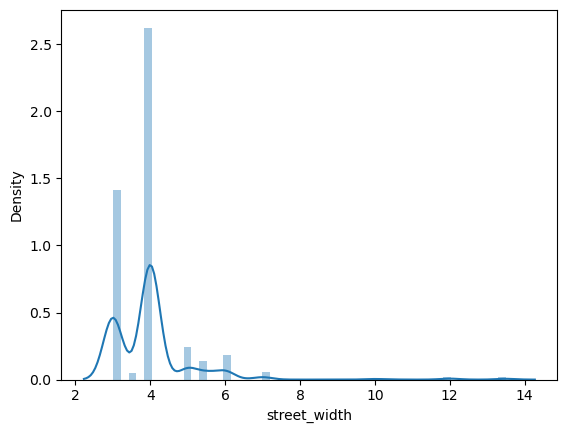

In [5]:
extension_area = gpd.read_file('data/select/extension_area_select.gpkg')


gdf_streets = gpd.read_file('data/select/gdf_streets_select.gpkg')

gdf_streets['uid'] = gdf_streets.index

gdf_streets.rename(columns={'largeur_de':'street_width'},inplace=True)
gdf_streets.street_width=gdf_streets.street_width.fillna(PARAM_default_street_width)


display(f'min street width={gdf_streets.street_width.min()}')
display(f'max street width={gdf_streets.street_width.max()}')
sns.distplot(gdf_streets.street_width)
plt.show()

In [6]:
display(gdf_streets[gdf_streets.street_width==0])

,n1,n2,n1_degree,n2_degree,street_width,nature,uid,geometry


## Ensure Street geometries are coords are 2D 

In [7]:
def convert_2D_line(geometry):
    if geometry.is_empty:
        return geometry
    if not isinstance(geometry,LineString):
        raise Exception(f'Only support simple LineString ({type(geometry)})')
    return LineString([x[0:2] for x in list(geometry.coords)])

In [8]:
gdf_streets['geometry'] = gdf_streets['geometry'].apply(convert_2D_line)

### Compute length

In [9]:
gdf_streets['length']=gdf_streets.length
display(gdf_streets.head(2))

,n1,n2,n1_degree,n2_degree,street_width,nature,uid,geometry,length
0,1119440,12350050,4,1,3.0,Route à 1 chaussée,0,"LINESTRING (1025242.300 6281649.600, 1025250.6...",84.307926
1,1119441,12350051,1,3,3.0,Route empierrée,1,"LINESTRING (1025177.500 6281541.100, 1025187.2...",97.823270


### Compute Dead ends

In [10]:
gdf_streets['dead_end_left']=gdf_streets.n1_degree==1
gdf_streets['dead_end_right']=gdf_streets.n2_degree==1
display(gdf_streets.head(2))

,n1,n2,n1_degree,n2_degree,street_width,nature,uid,geometry,length,dead_end_left,dead_end_right
0,1119440,12350050,4,1,3.0,Route à 1 chaussée,0,"LINESTRING (1025242.300 6281649.600, 1025250.6...",84.307926,False,True
1,1119441,12350051,1,3,3.0,Route empierrée,1,"LINESTRING (1025177.500 6281541.100, 1025187.2...",97.823270,True,False


# DATA - Load Consolidated buildings
* Add buffer corresponding to possible buildings around each roads

<Axes: >

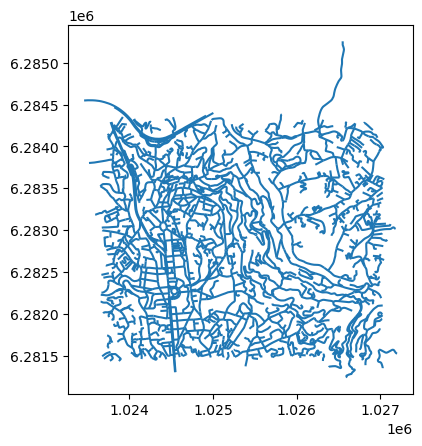

In [11]:
gdf_streets.plot()

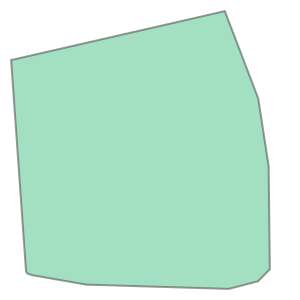

,H,inbiac_clu,uid,geometry
0,13.2,0,0,"POLYGON Z ((1024535.100 6282147.000 45.100, 10..."
1,0.0,0,1,"POLYGON Z ((1023879.100 6281337.000 -1000.000,..."
2,11.7,3,2,"POLYGON Z ((1023759.600 6281395.700 74.200, 10..."
3,0.0,0,3,"POLYGON Z ((1023919.400 6281454.000 -1000.000,..."
4,0.0,0,4,"POLYGON Z ((1023518.700 6282255.800 -1000.000,..."
...,...,...,...,...
12087,4.6,16,12087,"POLYGON Z ((1024537.300 6284036.200 149.000, 1..."
12088,5.3,15,12088,"POLYGON Z ((1024893.300 6284244.700 195.950, 1..."
12089,4.3,0,12089,"POLYGON Z ((1026453.200 6284235.900 207.600, 1..."
12090,9.1,0,12090,"POLYGON Z ((1024450.700 6281644.500 37.900, 10..."


In [12]:
# 1: Take all street points (in street geometry) from all street of the study area -> multipoints
# 2: Create a convex Hull from multipoints -> HULL
# 3: Extend (buffer) the HULL with the max between the sighline depth r/l and f/b (chosen parameter) -> Extended Hull 
# 4: Load Building (already consolidted and clustered) witihn the Extended Hull 


# 1:
points = []
for i,res in gdf_streets.iterrows():
    for pt in res.geometry.coords:
        points.append(pt) 
mpt = MultiPoint(points)

# 2:
hull = mpt.convex_hull
display(hull)
del points

# 3:
building_extension_area =  hull.buffer(max(PARAM_sight_line_width,PARAM_tan_line_width))

# 4:
gdf_buildings = gpd.read_file('data/select/gdf_buildings_select.gpkg')

gdf_buildings.rename(columns={'height':'H'},inplace=True)

gdf_buildings['uid']=gdf_buildings.index
display(gdf_buildings)

### Filter building with H=0 in the overall process

In [13]:
display(f'{len(gdf_buildings)} buildings total')
gdf_buildings=gdf_buildings[gdf_buildings.H!=0]
display(f'{len(gdf_buildings)} buildings filtered (H!=0)')

'12092 buildings total'

'9352 buildings filtered (H!=0)'

### Building area

In [14]:
gdf_buildings['area'] = gdf_buildings.area

### Buildings categories
* V1 (Current) categorized from area <span style='color:red'>DEPRECATED</span>
* V2 (pending INBIAC) from clustering

In [15]:
gdf_buildings['category'] =gdf_buildings['inbiac_clu']

#PARAM_building_category_count = len(buildings_categories_ids)

if gdf_buildings.category.min()<0:
    raise Exception('Each building category must be >=0')
PARAM_building_category_count = gdf_buildings.category.max()+1
display(PARAM_building_category_count)    


buildings_categories_ids = list(range(PARAM_building_category_count))
display(f'buildings_categories_ids{buildings_categories_ids}')


for id in buildings_categories_ids:
    gdf_tmp =gdf_buildings[gdf_buildings['category'] == id]
    display(f' * category {id} : count: {len(gdf_tmp)} min={round(gdf_tmp["area"].min(),1)} m², max={round(gdf_tmp["area"].max(),1)} m²')


17

'buildings_categories_ids[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]'

' * category 0 : count: 1687 min=0.5 m², max=15662.0 m²'

' * category 1 : count: 861 min=12.0 m², max=149.9 m²'

' * category 2 : count: 30 min=50.7 m², max=148.2 m²'

' * category 3 : count: 802 min=16.4 m², max=283.2 m²'

' * category 4 : count: 70 min=154.7 m², max=805.9 m²'

' * category 5 : count: 58 min=603.3 m², max=2729.1 m²'

' * category 6 : count: 66 min=150.9 m², max=913.2 m²'

' * category 7 : count: 131 min=301.6 m², max=1777.6 m²'

' * category 8 : count: 377 min=156.4 m², max=1109.8 m²'

' * category 9 : count: 198 min=312.1 m², max=3478.8 m²'

' * category 10 : count: 34 min=601.0 m², max=1973.8 m²'

' * category 11 : count: 64 min=78.7 m², max=592.7 m²'

' * category 12 : count: 178 min=150.1 m², max=551.6 m²'

' * category 13 : count: 170 min=151.4 m², max=580.3 m²'

' * category 14 : count: 2964 min=15.2 m², max=222.4 m²'

' * category 15 : count: 529 min=150.0 m², max=1571.0 m²'

' * category 16 : count: 1133 min=150.1 m², max=599.9 m²'

# Rtree (s)  spatial indexing of objects

In [16]:
class RtreeIndex:
    gdf = None
    rtree_index = None
    geom_rtree_list = None
    uid_rtree_list = None
    name = None
    verbose_function = None

    def __init__(self, name, gdf, verbose_function=None):
        self.name = name
        self.gdf = gdf
        self.verbose_function=verbose_function
        rtree_index = rtree.index.Index()
        # build spatial index
        self.log("rtree creation...")
        geom_rtree_list = []
        uid_rtree_list = []
        rtree_id = 0
        for uid, res in gdf.iterrows():
            geom = res.geometry
            geom_rtree_list.append(geom)
            uid_rtree_list.append(uid)
            rtree_index.insert(rtree_id, geom.bounds)
            rtree_id += 1
        self.log("rtree built.")
        self.rtree_index = rtree_index
        self.geom_rtree_list = geom_rtree_list
        self.uid_rtree_list = uid_rtree_list

    def extract_ids(self, intersecting_geom):
        iterator = self.rtree_index.intersection(intersecting_geom.bounds)
        result = []
        for rtree_position in iterator:
            geom = self.geom_rtree_list[rtree_position]
            if not geom.is_valid:
                geom = geom.buffer(-0.001)
            isect = intersecting_geom.intersection(geom)
            if not isect.is_empty:
                result.append(rtree_position)
        return result

    def select(self, ids):
        return self.gdf.iloc[ids]

    def log(self, message):
        if self.verbose_function is not None:
            self.verbose_function(f'RTREE[{self.name}]: {message}')

In [17]:
## Build Spatial indexes
rtree_streets = RtreeIndex("streets", gdf_streets)

rtree_buildings = RtreeIndex("buildings", gdf_buildings)

# Visualization tools 

In [18]:
SIGHTLINE_LEFT  = 0
SIGHTLINE_RIGHT = 1
SIGHTLINE_FRONT = 2
SIGHTLINE_BACK = 3


SIGHTLINE_WIDTH_PER_SIGHT_TYPE = [PARAM_sight_line_width,
                                PARAM_sight_line_width,
                                PARAM_tan_line_width,
                                PARAM_tan_line_width,]

In [19]:
def rotate(x,y,xo,yo,theta): #rotate x,y around xo,yo by theta (rad)
    xr=math.cos(theta)*(x-xo)-math.sin(theta)*(y-yo)   + xo
    yr=math.sin(theta)*(x-xo)+math.cos(theta)*(y-yo)  + yo
    return [xr,yr]

rad_90 = np.deg2rad(90)

def extend_line_end(line, distance):
    coords = line.coords
    nbp = len(coords)

    len_ext = distance + 1  # eps

    # extend line start point
    Ax, Ay = coords[0]
    Bx, By = coords[1]

    # extend line end point
    Ax, Ay = coords[nbp - 1]
    Bx, By = coords[nbp - 2]
    lenAB = math.sqrt((Ax - Bx) ** 2 + (Ay - By) ** 2);
    xe = Ax + (Ax - Bx) / lenAB * len_ext;
    ye = Ay + (Ay - By) / lenAB * len_ext;

    # return LineString([[xs,ys]]+coords[1:nbp]+[[xe,ye]])
    return LineString(coords[0:nbp - 1] + [[xe, ye]])

def lines_angle(l1, l2):
    v1_a = l1.coords[0]
    v1_b = l1.coords[-1]
    v2_a = l2.coords[0]
    v2_b = l2.coords[-1]
    start_x = v1_b[0] - v1_a[0]
    start_y = v1_b[1] - v1_a[1]
    dest_x = v2_b[0] - v2_a[0]
    dest_y = v2_b[1] - v2_a[1]
    AhAB = math.atan2((dest_y), (dest_x))
    AhAO = math.atan2((start_y), (start_x))

    ab = AhAB - AhAO
    # calc radian
    if ab > math.pi:
        angle = ab + (-2 * math.pi)
    else:
        if ab < 0 - math.pi:
            angle = ab + (2 * math.pi)
        else:
            angle = ab + 0
    # return #np.rad2deg(angle)
    return np.rad2deg(angle)

In [20]:
# return None if no sight line could be build du to total road length
def compute_sight_lines(line,
                        profile_spacing,
                        sightline_width,
                        tanline_witdh,
                        junction_size=0.5,
                        angle_tolerance=5,
                        dead_end_start=False,
                        dead_end_end=False):
    
    ################### FIRTS PART : PERPENDICULAR SIGHTLINES #################################
   
    # Calculate the number of profiles to generate
    line_length = line.length

    remaining_length = line_length - 2 * junction_size
    if remaining_length < profile_spacing:
        # no sight line
        return None, None,None

    distances = [junction_size]
    nb_inter_nodes = int(math.floor(remaining_length / profile_spacing))
    offset = remaining_length / nb_inter_nodes
    distance = junction_size

    for i in range(0, nb_inter_nodes):
        distance = distance + offset
        distances.append(distance)

    # n_prof = int(line.length/profile_spacing)

    results_sight_points = []
    results_sight_points_distances = []            
    results_sight_lines = []            
    
    previous_sigh_line_left = None
    previous_sigh_line_right = None

    # semi_ortho_segment_size = profile_spacing/2
    semi_ortho_segment_size = junction_size / 2

    # display(distances)
    # display(line_length)

    sightline_index = 0

    last_pure_sightline_left_position_in_array = -1

    FIELD_geometry = 0
    FIELD_uid = 1
    FIELD_dist = 2
    FIELD_type = 3

    ################### SECOND PART : TANGENT SIGHTLINES #################################
    
    prev_distance = 0
    # Start iterating along the line
    for distance in distances:
        # Get the start, mid and end points for this segment

        seg_st = line.interpolate((distance - semi_ortho_segment_size))
        seg_mid = line.interpolate(distance)
        seg_end = line.interpolate(distance + semi_ortho_segment_size)

        # Get a displacement vector for this segment
        vec = np.array([[seg_end.x - seg_st.x, ], [seg_end.y - seg_st.y, ]])

        # Rotate the vector 90 deg clockwise and 90 deg counter clockwise
        rot_anti = np.array([[0, -1], [1, 0]])
        rot_clock = np.array([[0, 1], [-1, 0]])
        vec_anti = np.dot(rot_anti, vec)
        vec_clock = np.dot(rot_clock, vec)

        # Normalise the perpendicular vectors
        len_anti = ((vec_anti ** 2).sum()) ** 0.5
        vec_anti = vec_anti / len_anti
        len_clock = ((vec_clock ** 2).sum()) ** 0.5
        vec_clock = vec_clock / len_clock

        # Scale them up to the profile length
        vec_anti = vec_anti * sightline_width
        vec_clock = vec_clock * sightline_width

        # Calculate displacements from midpoint
        prof_st = (seg_mid.x + float(vec_anti[0]), seg_mid.y + float(vec_anti[1]))
        prof_end = (seg_mid.x + float(vec_clock[0]), seg_mid.y + float(vec_clock[1]))

        results_sight_points.append(seg_mid)
        results_sight_points_distances.append(distance)
        
        
        sight_line_left = LineString([seg_mid, prof_st])
        sight_line_right = LineString([seg_mid, prof_end])

        # append LEFT sight line
        rec = [sight_line_left,  # FIELD_geometry
               sightline_index,  # FIELD_uid
               SIGHTLINE_LEFT    # FIELD_type
               ]
        results_sight_lines.append(rec)

        # back up for dead end population
        last_pure_sightline_left_position_in_array = len(results_sight_lines) - 1

        # append RIGHT sight line
        rec = [sight_line_right, # FIELD_geometry
               sightline_index,  # FIELD_uid
               SIGHTLINE_RIGHT   # FIELD_type
               ]
        results_sight_lines.append(rec)

        line_tan_back = LineString([seg_mid, rotate(prof_end[0], prof_end[1], seg_mid.x, seg_mid.y, rad_90)])
        line_tan_front = LineString([seg_mid, rotate(prof_st[0], prof_st[1], seg_mid.x, seg_mid.y, rad_90)])
        
        #extends tanline to reach parametrized width
        line_tan_back=extend_line_end(line_tan_back,tanline_witdh)
        line_tan_front=extend_line_end(line_tan_front,tanline_witdh)

        # append tangent sigline front view
        rec = [line_tan_back,  # FIELD_geometry
               sightline_index,  # FIELD_type
               SIGHTLINE_BACK
              ]
        results_sight_lines.append(rec)

        # append tangent sigline front view
        rec = [line_tan_front,  # FIELD_geometry
               sightline_index,  # FIELD_uid
               SIGHTLINE_FRONT
               ]
        results_sight_lines.append(rec)

    ################### THIRD PART: SIGHTLINE ENRICHMENT #################################
    
        # Populate lost space between consecutive sight lines with high deviation (>angle_tolerance)
        if not previous_sigh_line_left is None:
            for this_line, prev_line, side in [(sight_line_left, previous_sigh_line_left, SIGHTLINE_LEFT),
                                               (sight_line_right, previous_sigh_line_right, SIGHTLINE_RIGHT)]:
                # angle between consecutive sight line
                deviation = round(lines_angle(prev_line, this_line), 1)
                # DEBUG_VALUES.append([this_line.coords[1],deviation])
                # condition 1: large deviation
                if abs(deviation) <= angle_tolerance:
                    continue
                # condition 1: consecutive sight lines do not intersect

                if this_line.intersects(prev_line):
                    continue

                nb_new_sight_lines = int(math.floor(abs(deviation) / angle_tolerance))
                nb_new_sight_lines_this = nb_new_sight_lines // 2
                nb_new_sight_lines_prev = nb_new_sight_lines - nb_new_sight_lines_this
                delta_angle = deviation / (nb_new_sight_lines)
                theta_rad = np.deg2rad(delta_angle)

                # add S2 new sight line on previous one
                angle = 0
                for i in range(0, nb_new_sight_lines_this):
                    angle -= theta_rad
                    x0 = this_line.coords[0][0]
                    y0 = this_line.coords[0][1]
                    x = this_line.coords[1][0]
                    y = this_line.coords[1][1]
                    new_line = LineString([this_line.coords[0], rotate(x, y, x0, y0, angle)])
                    rec = [new_line,  # FIELD_geometry
                           sightline_index,  # FIELD_uid
                           side,  # FIELD_type
                           ]
                    results_sight_lines.append(rec)

                    # add S2 new sight line on this current sight line
                angle = 0
                for i in range(0, nb_new_sight_lines_prev):
                    angle += theta_rad
                    x0 = prev_line.coords[0][0]
                    y0 = prev_line.coords[0][1]
                    x = prev_line.coords[1][0]
                    y = prev_line.coords[1][1]
                    new_line = LineString([prev_line.coords[0], rotate(x, y, x0, y0, angle)])
                    rec = [new_line,  # FIELD_geometry
                           sightline_index - 1,  # FIELD_uid
                           side  # FIELD_type
                           ]
                    results_sight_lines.append(rec)

        # =========================================

        # iterate
        previous_sigh_line_left = sight_line_left
        previous_sigh_line_right = sight_line_right

        sightline_index += 1
        prev_distance = distance

    # ======================================================================================
    # SPECIFIC ENRICHMENT FOR SIGHTPOINTS corresponding to DEAD ENDs
    # ======================================================================================
    if dead_end_start or dead_end_end:
        for prev_sg, this_sg, dead_end in [(results_sight_lines[0],
                                            results_sight_lines[1], dead_end_start),
                                           (results_sight_lines[last_pure_sightline_left_position_in_array + 1],
                                            results_sight_lines[last_pure_sightline_left_position_in_array], dead_end_end)]:
            if not dead_end:
                continue
            # angle between consecutive dead end sight line LEFT and RIGHT (~180)
            prev_line = prev_sg[FIELD_geometry]  # FIRST sight line LEFT side
            this_line = this_sg[FIELD_geometry]  # FIRST sight line LEFT side

            # special case --> dead end .. so 180 °
            deviation = 180

            nb_new_sight_lines = int(math.floor(abs(deviation) / angle_tolerance))
            nb_new_sight_lines_this = nb_new_sight_lines // 2
            nb_new_sight_lines_prev = nb_new_sight_lines - nb_new_sight_lines_this
            delta_angle = deviation / (nb_new_sight_lines)
            theta_rad = np.deg2rad(delta_angle)

            # add S2 new sight line on previous one
            angle = 0
            for i in range(0, nb_new_sight_lines_this):
                angle -= theta_rad
                x0 = this_line.coords[0][0]
                y0 = this_line.coords[0][1]
                x = this_line.coords[1][0]
                y = this_line.coords[1][1]
                new_line = LineString([this_line.coords[0], rotate(x, y, x0, y0, angle)])

                rec = [new_line,  # FIELD_geometry
                       this_sg[FIELD_uid],  # FIELD_uid
                       SIGHTLINE_LEFT
                       ]
                results_sight_lines.append(rec)

                # add S2 new sight line on this current sight line
            angle = 0
            for i in range(0, nb_new_sight_lines_prev):
                angle += theta_rad
                x0 = prev_line.coords[0][0]
                y0 = prev_line.coords[0][1]
                x = prev_line.coords[1][0]
                y = prev_line.coords[1][1]
                new_line = LineString([prev_line.coords[0], rotate(x, y, x0, y0, angle)])
                rec = [new_line,  # FIELD_geometry
                       prev_sg[FIELD_uid],  # FIELD_uid
                       SIGHTLINE_RIGHT
                       ]
                results_sight_lines.append(rec)
        # ======================================================================================
    return gpd.GeoDataFrame(results_sight_lines, columns=['geometry',
                                                          'point_id',
                                                          'sight_type']), results_sight_points, results_sight_points_distances

# UNITTEST on one road 

In [21]:
if PARAM_DEBUG_sample_street_uid is not None:
    id_st= PARAM_DEBUG_sample_street_uid
    display(f'id_st={id_st}')
    street_geom = gdf_streets.loc[id_st]

    results_sight_lines, results_sight_points,results_sight_points_distances  = compute_sight_lines(
                                              street_geom.geometry,
                                              profile_spacing = PARAM_sight_line_spacing, 
                                              sightline_width = PARAM_sight_line_width,            
                                              tanline_witdh= PARAM_tan_line_width,            
                                              junction_size = PARAM_sight_line_junction_size,
                                              angle_tolerance = PARAM_sight_line_angle_tolerance,
                                              dead_end_start = street_geom.dead_end_left,
                                              dead_end_end =  street_geom.dead_end_right)

    #results_sight_lines.plot()
    display(results_sight_lines.tail(50))

# MAIN PROCESS

In [22]:
def to_sightline_dataframe(values):
    df =   pd.DataFrame(values,
                        columns=['uid', 
                                 'sight_line_points',
                                 'left_OS_count',
                                 'left_OS',
                                 'left_SB_count',
                                 'left_SB',
                                 'left_H',
                                 'left_HW', 
                                 'left_BUILT_COVERAGE',
                                 'left_SEQ_SB_ids',
                                 'left_SEQ_SB_categories',
                                 'right_OS_count',
                                 'right_OS',
                                 'right_SB_count',
                                 'right_SB',
                                 'right_H',
                                 'right_HW',
                                 'right_BUILT_COVERAGE',
                                 'right_SEQ_SB_ids',
                                 'right_SEQ_SB_categories',
                                 'front_SB',
                                 'back_SB',
                                 'left_SEQ_OS_endpoints',
                                 'right_SEQ_OS_endpoints',
                                 
                                ])
    df= df.set_index('uid',drop=False)
    return df

In [23]:
def compute_sigthlines_indicators_optimized(street_row, optimize_on=True):
   
    street_uid = street_row.uid    
    street_geom = street_row.geometry    
    
    
    
    gdf_sight_lines, sight_lines_points,results_sight_points_distances  = compute_sight_lines(
                                          street_geom,
                                          profile_spacing = PARAM_sight_line_spacing, 
                                          sightline_width = PARAM_sight_line_width,            
                                          tanline_witdh= PARAM_tan_line_width,            
                                          junction_size = PARAM_sight_line_junction_size,
                                          angle_tolerance = PARAM_sight_line_angle_tolerance,
                                          dead_end_start = street_row.dead_end_left,
                                          dead_end_end =  street_row.dead_end_right)

    
    
    #display(gdf_sight_lines)
    
    # per street sightpoints indicators
    current_street_uid = street_uid
    current_street_sight_lines_points = sight_lines_points    
    current_street_left_OS_count = []
    current_street_left_OS = []
    current_street_left_SB_count = []
    current_street_left_SB = []
    current_street_left_H = []
    current_street_left_HW = []
    current_street_right_OS_count = []
    current_street_right_OS = []
    current_street_right_SB_count = []
    current_street_right_SB = []
    current_street_right_H = []
    current_street_right_HW = []
  
       
    current_street_left_BUILT_COVERAGE = []
    current_street_right_BUILT_COVERAGE = []
    
    # SPARSE STORAGE (one value if set back is OK ever in intersightline)    
    current_street_left_SEQ_SB_ids=[]
    current_street_left_SEQ_SB_categories=[]
    current_street_right_SEQ_SB_ids=[]
    current_street_right_SEQ_SB_categories=[]
    
    current_street_front_sb = []
    current_street_back_sb = []
    
    # [Expanded] each time a sight line or intersight line occured
    left_SEQ_sight_lines_end_points = []
    right_SEQ_sight_lines_end_points = []
    
    
    if sight_lines_points is None:
        current_street_sight_lines_points = []
        return [current_street_uid,
                current_street_sight_lines_points,
                current_street_left_OS_count,
                current_street_left_OS,
                current_street_left_SB_count,
                current_street_left_SB,
                current_street_left_H,
                current_street_left_HW,
                current_street_left_BUILT_COVERAGE,
                current_street_left_SEQ_SB_ids,
                current_street_left_SEQ_SB_categories,    
                current_street_right_OS_count,
                current_street_right_OS,
                current_street_right_SB_count,
                current_street_right_SB,
                current_street_right_H,
                current_street_right_HW,
                current_street_right_BUILT_COVERAGE,
                current_street_right_SEQ_SB_ids,
                current_street_right_SEQ_SB_categories,
                current_street_front_sb,
                current_street_back_sb,
                left_SEQ_sight_lines_end_points,
                right_SEQ_sight_lines_end_points
                ], None
    
    #------- SIGHT LINES
    # Extract building in SIGHTLINES buffer (e.g: 50m)    
    # gdf_street_buildings = gdf_buildings.iloc[rtree_buildings.extract_ids(street_geom.buffer(sight_line_width))]
    # building_count = len(gdf_street_buildings)        
    
    # iterate throught sightlines groups.
    # Eeach sigh points could have many sub sighpoint in case of snail effect)
    for point_id, group in gdf_sight_lines.groupby('point_id'):        
        front_sl_tan_sb = PARAM_tan_line_width    
        back_sl_tan_sb = PARAM_tan_line_width
        left_sl_count = 0 
        left_sl_distance_total = 0     
        left_sl_building_count = 0
        left_sl_building_sb_total = 0
        left_sl_building_sb_height_total = 0 
        right_sl_count = 0 
        right_sl_distance_total = 0     
        right_sl_building_count = 0
        right_sl_building_sb_total = 0
        right_sl_building_sb_height_total = 0 
        
        left_sl_coverage_ratio_total = 0
        right_sl_coverage_ratio_total = 0
        
      
        
        
        
        # iterate throught each sightline links to the sigh point: LEFT(1-*),RIGHT(1-*),FRONT(1), BACK(1)
        for i_sg, row_s in group.iterrows():
            sight_line_geom = row_s.geometry
            sight_line_side = row_s.sight_type
            sight_line_width = SIGHTLINE_WIDTH_PER_SIGHT_TYPE[sight_line_side]
            # extract possible candidates            
            if  optimize_on and sight_line_side >=SIGHTLINE_FRONT:
                # ========== OPTIM TEST
                # cut tan line in 3 block (~100m)
                length_3 = sight_line_geom.length/3.0
                A = sight_line_geom.coords[0]
                B = sight_line_geom.coords[-1]
                end_points = [sight_line_geom.interpolate(length_3),
                              sight_line_geom.interpolate(length_3*2),                              
                              B]
                
                gdf_sight_line_buildings = None
                start_point = A
                for end_point in end_points:
                    sub_line = LineString([start_point,end_point])
                    gdf_sight_line_buildings = gdf_buildings.iloc[rtree_buildings.extract_ids(sub_line)]
                    if len(gdf_sight_line_buildings)>0:
                        break
                    start_point=end_point                
            else:
                gdf_sight_line_buildings = gdf_buildings.iloc[rtree_buildings.extract_ids(sight_line_geom)]
                        
            s_pt1 = Point(sight_line_geom.coords[0])
            endpoint = Point(sight_line_geom.coords[-1])
            
            # agregate
            match_sl_distance = sight_line_width # set max distance if no polygon intersect
            match_sl_building_id = None
            match_sl_building_category = None
            match_sl_building_height = 0

            
            sl_coverage_ratio_total = 0
            for i,res in gdf_sight_line_buildings.iterrows():   
                # building geom
                geom = res.geometry
                geom = geom if isinstance(geom,Polygon) else geom.geoms[0] 
                building_ring = LineString(geom.exterior.coords)        
                isect = sight_line_geom.intersection(building_ring)    
                if not isect.is_empty:        
                    if isinstance(isect,Point):
                        isect=[isect]
                    elif isinstance(isect,LineString):
                        isect = [Point(coord) for coord in isect.coords]
                    elif isinstance(isect,MultiPoint):
                        isect = [pt for pt in isect.geoms]
                        
                    
                    for pt_sec in isect:
                        dist = s_pt1.distance(pt_sec)
                        if dist < match_sl_distance:
                            match_sl_distance = dist                          
                            match_sl_building_id = res.uid
                            match_sl_building_height = res.H
                            match_sl_building_category = res.category
                            
                    
                    # coverage ratio between sight line and candidate building (geom: building geom)
                    _coverage_isec = sight_line_geom.intersection(geom)
                    #display(type(coverage_isec))
                    sl_coverage_ratio_total += _coverage_isec.length                    
                    

            if sight_line_side == SIGHTLINE_LEFT:
                left_sl_count += 1 
                left_SEQ_sight_lines_end_points.append(endpoint)
                left_sl_distance_total += match_sl_distance                                         
                left_sl_coverage_ratio_total+=sl_coverage_ratio_total
                if match_sl_building_id:
                    left_sl_building_count += 1
                    left_sl_building_sb_total += match_sl_distance
                    left_sl_building_sb_height_total += match_sl_building_height
                    # PREVALENCE: Emit each time a new setback or INTER-setback is found (campact storage structure)
                    current_street_left_SEQ_SB_ids.append(match_sl_building_id)
                    current_street_left_SEQ_SB_categories.append(match_sl_building_category)
                
                    
            elif sight_line_side == SIGHTLINE_RIGHT:
                right_sl_count += 1 
                right_SEQ_sight_lines_end_points.append(endpoint)
                right_sl_distance_total += match_sl_distance
                right_sl_coverage_ratio_total+=sl_coverage_ratio_total
                if match_sl_building_id:
                    right_sl_building_count += 1
                    right_sl_building_sb_total += match_sl_distance
                    right_sl_building_sb_height_total += match_sl_building_height
                    # PREVALENCE: Emit each time a new setback or INTER-setback is found (campact storage structure)
                    current_street_right_SEQ_SB_ids.append(match_sl_building_id)
                    current_street_right_SEQ_SB_categories.append(match_sl_building_category)
                    
            elif sight_line_side == SIGHTLINE_BACK:
                back_sl_tan_sb = match_sl_distance    
            elif sight_line_side == SIGHTLINE_FRONT:
                front_sl_tan_sb = match_sl_distance   
                
            
                
        
        # LEFT
        left_OS_count = left_sl_count 
        left_OS = left_sl_distance_total/left_OS_count
        left_SB_count = left_sl_building_count
        left_SB = math.nan
        left_H = math.nan
        left_HW = math.nan
        if left_SB_count!=0:
            left_SB = left_sl_building_sb_total/left_SB_count 
            left_H = left_sl_building_sb_height_total/left_SB_count
            # HACk if SB = 0 --> 10cm
            left_HW = left_H/max(left_SB,0.1) 
        left_COVERAGE_RATIO = left_sl_coverage_ratio_total/left_OS_count
        # RIGHT
        right_OS_count = right_sl_count 
        right_OS = right_sl_distance_total/right_OS_count
        right_SB_count = right_sl_building_count
        right_SB = math.nan
        right_H = math.nan
        right_HW = math.nan
        if right_SB_count!=0:
            right_SB = right_sl_building_sb_total/right_SB_count 
            right_H = right_sl_building_sb_height_total/right_SB_count
            # HACk if SB = 0 --> 10cm            
            right_HW = right_H/max(right_SB,0.1)
        right_COVERAGE_RATIO = right_sl_coverage_ratio_total/right_OS_count
        
        current_street_left_OS_count.append(left_OS_count)
        current_street_left_OS.append(left_OS)
        current_street_left_SB_count.append(left_SB_count)
        current_street_left_SB.append(left_SB)
        current_street_left_H.append(left_H)
        current_street_left_HW.append(left_HW)
        current_street_right_OS_count.append(right_OS_count)
        current_street_right_OS.append(right_OS)
        current_street_right_SB_count.append(right_SB_count)
        current_street_right_SB.append(right_SB)
        current_street_right_H.append(right_H)
        current_street_right_HW.append(right_HW)
        # FRONT / BACK        
        current_street_front_sb.append(front_sl_tan_sb)
        current_street_back_sb.append(back_sl_tan_sb)     
        # COverage ratio Built up
        current_street_left_BUILT_COVERAGE.append(left_COVERAGE_RATIO)
        current_street_right_BUILT_COVERAGE.append(right_COVERAGE_RATIO)
            
    
    #------- TAN LINES
    # Extract building in TANLINES buffer (e.g: 300m)
    #gdf_street_buildings = gdf_buildings.iloc[rtree_buildings.extract_ids(street_geom.buffer(PARAM_tan_line_width))]
    #building_count = len(gdf_street_buildings)
    
    
    
    
    
    return [current_street_uid,
            current_street_sight_lines_points,            
            current_street_left_OS_count,
            current_street_left_OS,
            current_street_left_SB_count,
            current_street_left_SB,
            current_street_left_H,
            current_street_left_HW,
            current_street_left_BUILT_COVERAGE,
            current_street_left_SEQ_SB_ids,
            current_street_left_SEQ_SB_categories,    
            current_street_right_OS_count,
            current_street_right_OS,
            current_street_right_SB_count,
            current_street_right_SB,
            current_street_right_H,
            current_street_right_HW,
            current_street_right_BUILT_COVERAGE,
            current_street_right_SEQ_SB_ids,
            current_street_right_SEQ_SB_categories,
            current_street_front_sb,
            current_street_back_sb,
            left_SEQ_sight_lines_end_points,
            right_SEQ_sight_lines_end_points
            ], gdf_sight_lines
    

    
    
compute_sigthlines_indicators = compute_sigthlines_indicators_optimized    

# UNIT TEST - SAMPLE ROAD

In [24]:
def DEBUG_street_processing(street_uid):
    
    start_time = time.time()    
    street_row = gdf_streets.loc[street_uid]
    
    values , gdf_sight_lines = compute_sigthlines_indicators(street_row)
    df_sightlines = to_sightline_dataframe([values])
    display(f'Computation DONE ({time.time()/start_time} seconds).')
    
    
    # DISPLAY         
    street_geom = street_row.geometry    
    if gdf_sight_lines is None:
        display('No sight lines for this geometry!')
        return
    
    
    set_back_points = [Point(line.coords[-1]) for line in gdf_sight_lines.geometry.values]
    sight_points = [Point(line.coords[0]) for line in gdf_sight_lines.geometry.values]
    
    
    fig,ax = plt.subplots(1,1,figsize=(20,20))
    gpd.GeoDataFrame([street_geom],columns=['geometry']).plot(color='black',linewidth=3,ax=ax)
    gpd.GeoDataFrame(sight_points,columns=['geometry']).plot(color='black',markersize=50,ax=ax)
    
    
    gdf_street_buildings = gdf_buildings.iloc[rtree_buildings.extract_ids(street_geom.buffer(PARAM_sight_line_width))]
    #gdf_street_buildings.plot(ax=ax,color='silver')
    gdf_street_buildings.plot(ax=ax,column='category', categorical=True,cmap='Pastel2',legend=True,label='category')
    
    
    if  len(gdf_street_buildings[gdf_street_buildings.H==0])>0:
        gdf_street_buildings[gdf_street_buildings.H==0].plot(ax=ax,color='black')
        
        
    side_color_table=['green','lightblue'] 
    for side_type,side_color in zip([SIGHTLINE_LEFT,SIGHTLINE_RIGHT],side_color_table):
        gdf_side_main = gdf_sight_lines[gdf_sight_lines.sight_type==side_type].drop_duplicates(subset=['point_id'],keep='first')        
        gdf_side_snail = gdf_sight_lines[gdf_sight_lines.sight_type==side_type].drop(gdf_side_main.index)
    
        gdf_side_main.plot(color=side_color,linewidth=1,  ax=ax) if len(gdf_side_main)>0 else None
        gdf_side_snail.plot(color=side_color,linewidth=1,  ax=ax) if len(gdf_side_snail)>0 else None
        
    
    #gdf_street_buildings = extract_buildings(street_geom,sight_line_width)
    #gpd.GeoDataFrame(sight_lines_points,columns=['geometry']).plot(color='black',markersize=50,ax=ax)

    
    #ax.legend(gdf_street_buildings.category.unique())    
    plt.show()
    
    
    for side_type,side_name,side_color in zip([SIGHTLINE_LEFT,SIGHTLINE_RIGHT],['left','right'],side_color_table):
        fig,ax = plt.subplots(1,1,figsize=(20,5))
        row = df_sightlines.iloc[0]    
        var_name = f'{side_name}_BUILT_COVERAGE'
        y=row[var_name]
        x=list(range(len(y)))
        sns.barplot(data=None,x=x,y=y,color=side_color)
        ax.set_title(var_name)
        
        plt.show()
    
    # Indicators dataframe
    display(df_sightlines.transpose())
    
    left_SEQ_SB_ids = df_sightlines.iloc[0].left_SEQ_SB_ids
    right_SEQ_SB_ids = df_sightlines.iloc[0].right_SEQ_SB_ids
    left_SEQ_SB_categories = df_sightlines.iloc[0].left_SEQ_SB_categories
    left_SEQ_OS_endpoints = df_sightlines.iloc[0].left_SEQ_OS_endpoints
    left_SB_count = df_sightlines.iloc[0].left_SB_count
    left_OS_count = df_sightlines.iloc[0].left_OS_count
    display(f'left_SEQ_SB_ids={left_SEQ_SB_ids}')
    display(f'left_SEQ_SB_categories={left_SEQ_SB_categories}')
    #display(f'left_SEQ_OS_endpoints={left_SEQ_OS_endpoints}')
    display(f'left_SEQ_SB_ids count={len(left_SEQ_SB_ids)}')
    display(f'left_SEQ_SB_categories count={len(left_SEQ_SB_categories)}')
    display(f'left_SEQ_OS_endpoints count={len(left_SEQ_OS_endpoints)}')
    
    
    
    display(f'left_OS_count={left_OS_count}')
    display(f'left_SB_count={left_SB_count}')
    display(f'left total OS  count = N  = {sum(left_OS_count)}')
    display(f'left total SB* count = n* = {sum(left_SB_count)}')
    display(f'')
    display(f'right_SEQ_SB_ids={right_SEQ_SB_ids}')

    
for uid in PARAM_DEBUG_sample_street_uid_list:
    display(HTML(f'<h1><center>Sample road: {uid}</center><//h1>'))
    DEBUG_street_processing(uid)
#DEBUG_street_processing(357982425) cas particulier avec Setback =0

In [25]:
gc.collect()

5474

# DEBUG STREET

/tmp/ipykernel_63485/3908585784.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prof_st = (seg_mid.x + float(vec_anti[0]), seg_mid.y + float(vec_anti[1]))
/tmp/ipykernel_63485/3908585784.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prof_end = (seg_mid.x + float(vec_clock[0]), seg_mid.y + float(vec_clock[1]))


'Computation DONE (1.0000000002922373 seconds).'

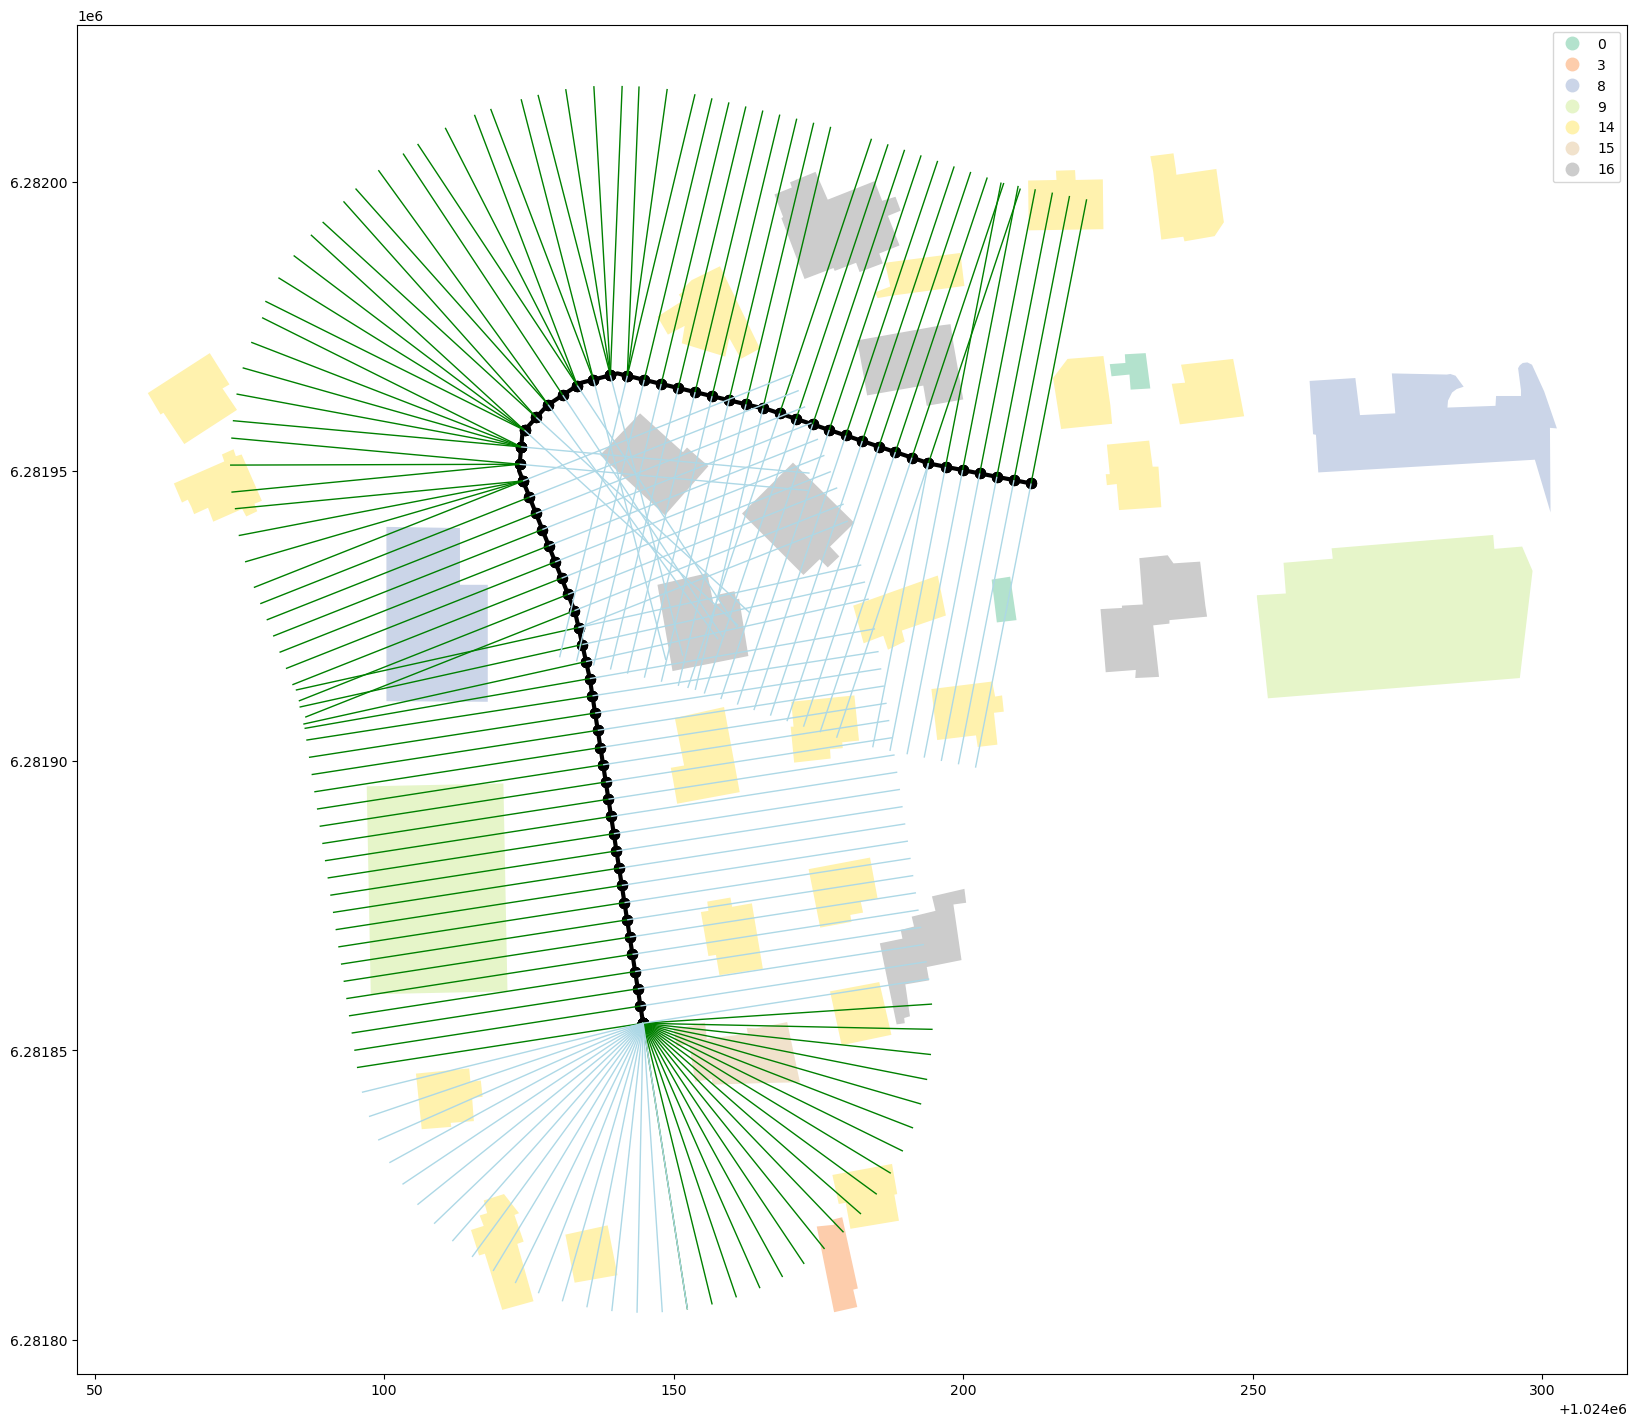

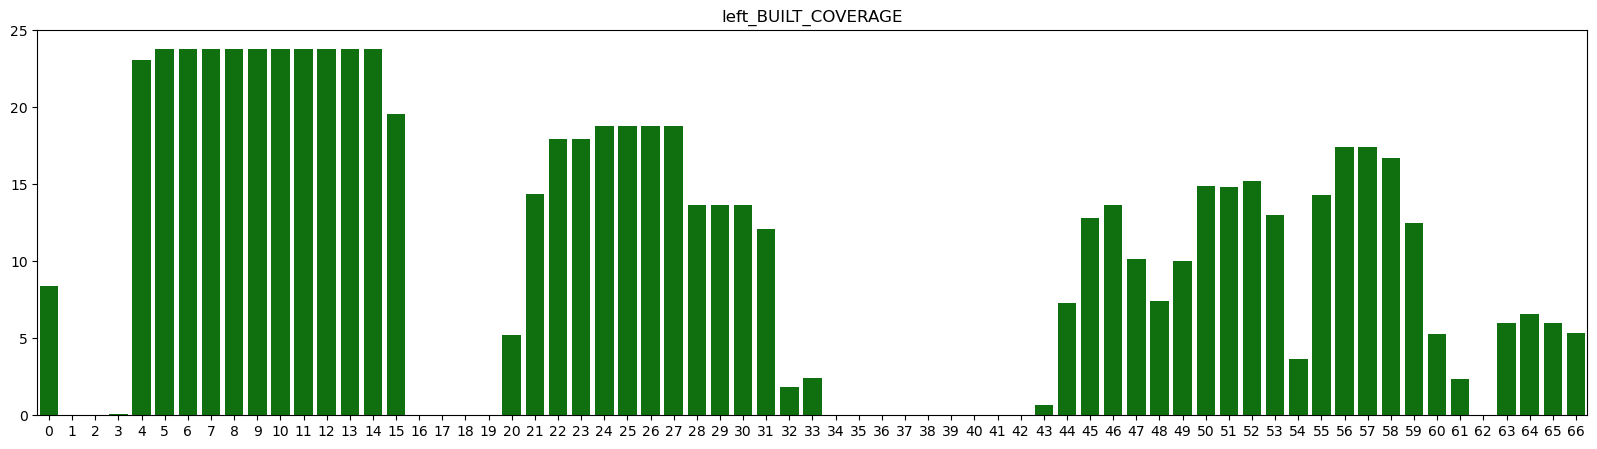

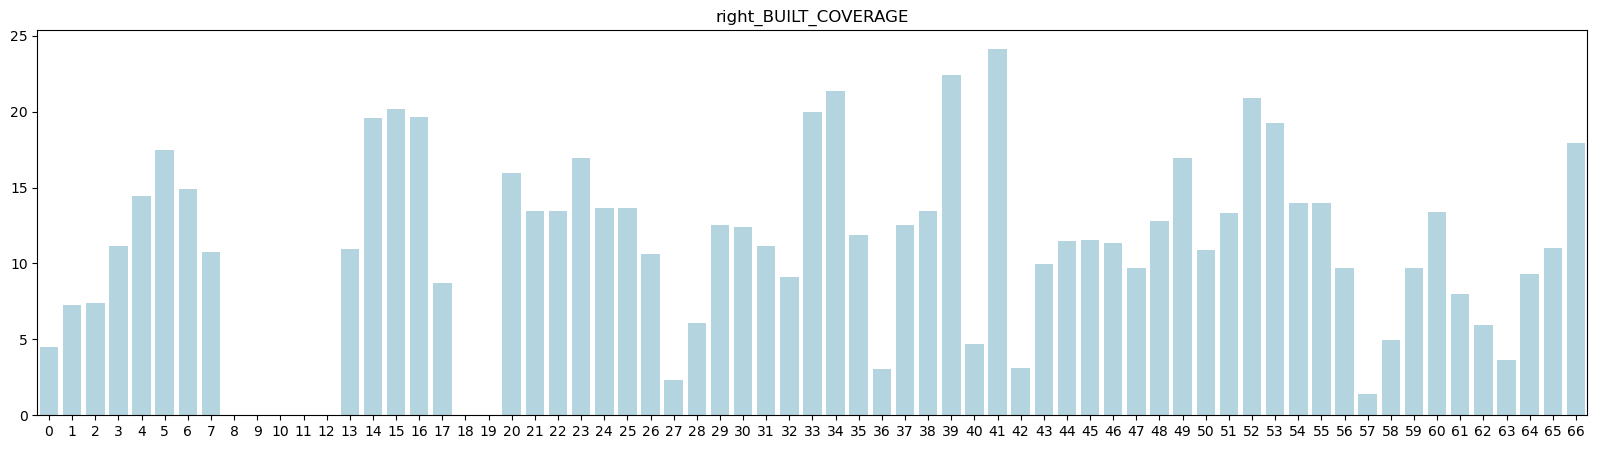

uid,2008
uid,2008
sight_line_points,"[POINT (1024144.7235389706 6281854.694119127),..."
left_OS_count,"[19, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
left_OS,"[26.956045020637518, 50.0, 50.0, 22.3048169939..."
left_SB_count,"[12, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
left_SB,"[13.513737949342735, nan, nan, 22.304816993993..."
left_H,"[4.075, nan, nan, 11.0, 11.0, 11.0, 11.0, 11.0..."
left_HW,"[0.3015449918649781, nan, nan, 0.4931670142356..."
left_BUILT_COVERAGE,"[8.417285848017393, 0.0, 0.0, 0.07086698594459..."
left_SEQ_SB_ids,"[5223, 704, 704, 704, 704, 704, 704, 704, 704,..."


'left_SEQ_SB_ids=[5223, 704, 704, 704, 704, 704, 704, 704, 704, 704, 704, 8081, 5970, 5970, 5970, 5970, 5970, 5970, 5970, 5970, 5970, 5970, 5970, 5970, 5970, 9572, 9572, 9572, 9572, 9572, 9572, 9572, 9572, 9572, 9572, 9572, 9572, 9572, 1067, 1067, 1067, 6337, 6337, 6337, 6337, 6337, 6337, 6337, 4843, 4843, 4843, 4843, 11406, 11406, 11406, 11406, 11406, 11406, 11406, 11406, 11255, 11255, 11255, 11255]'

'left_SEQ_SB_categories=[14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 14, 14, 14]'

'left_SEQ_SB_ids count=64'

'left_SEQ_SB_categories count=64'

'left_SEQ_OS_endpoints count=107'

'left_OS_count=[19, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 5, 4, 2, 2, 1, 3, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]'

'left_SB_count=[12, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]'

'left total OS  count = N  = 107'

'left total SB* count = n* = 64'

''

'right_SEQ_SB_ids=[5223, 2610, 2610, 2610, 2610, 6548, 6548, 6548, 6548, 7890, 7890, 7890, 8617, 8617, 10133, 10133, 10133, 10133, 4123, 1844, 1844, 1844, 1844, 1844, 11256, 11256, 11256, 11256, 11256, 2958, 2958, 2958, 2958, 2957, 2957, 2957, 2957, 2957, 2957, 2957, 11256, 11256, 11256, 2957, 2957, 2957, 2957, 2957, 2957, 2957, 2957, 2957, 2957, 11256, 11256, 11256, 2958, 2958, 2958, 2958, 2958, 2958, 2958, 11616, 7097, 7097, 7097, 7097, 7097, 3332, 3332, 10892, 10892]'

In [26]:
DEBUG_street_processing(2008)

# ALL STREETS - PROCESS

In [27]:
# MAIN PROCESS (overall streets)
values=[]

gdf_streets_subset = gdf_streets

for street_uid,street_row in gdf_streets_subset.iterrows():    
    indicators , gdf_sight_lines = compute_sigthlines_indicators(street_row)
    values.append(indicators)        

/tmp/ipykernel_63485/3908585784.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prof_st = (seg_mid.x + float(vec_anti[0]), seg_mid.y + float(vec_anti[1]))
/tmp/ipykernel_63485/3908585784.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prof_end = (seg_mid.x + float(vec_clock[0]), seg_mid.y + float(vec_clock[1]))
/tmp/ipykernel_63485/3908585784.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prof_st = (seg_mid.x + float(vec_anti[0]), seg_mid.y + float(

In [28]:
df_results=to_sightline_dataframe(values)

# Global streets indicators
depending on geometry and topology

## Indicator: Node degree 

In [29]:
df_results['nodes_degree_1'] = gdf_streets.apply(lambda row: ((1 if row.n1_degree==1 else 0)+(1 if row.n2_degree==1 else 0))/2,axis=1)

df_results['nodes_degree_4'] = gdf_streets.apply(lambda row: ((1 if row.n1_degree==4 else 0)+(1 if row.n2_degree==4 else 0))/2,axis=1)

df_results['nodes_degree_3_5_plus'] = gdf_streets.apply(lambda row: ((1 if row.n1_degree==3 or row.n1_degree>=5 else 0)+(1 if row.n2_degree==3 or row.n2_degree>=5 else 0))/2,axis=1)

## Indicators length/ windingness

In [30]:
df_results['street_length'] = gdf_streets.length
df_results['street_width'] = gdf_streets.street_width
df_results['windingness'] = gdf_streets.geometry.apply(lambda line:Point(line.coords[0]).distance(Point(line.coords[-1])))
df_results['windingness'] = 1 - (df_results['windingness']/df_results['street_length'])

In [31]:
df_results.head().transpose()

uid,0,1,2,3,4
uid,0,1,2,3,4
sight_line_points,"[POINT (1025242.6754464795 6281649.269788036),...","[POINT (1025177.5965266357 6281540.609405861),...","[POINT (1025425.00475656 6281582.356152114), P...",[POINT (1025475.9339181399 6281507.3043860495)...,"[POINT (1025215.6132290525 6281671.216872584),..."
left_OS_count,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[19, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
left_OS,"[50.0, 50.0, 50.0, 50.0, 50.0, 12.015897356951...","[40.782696695347134, 50.0, 50.0, 50.0, 42.7835...","[15.717847714157392, 21.750924092019908, 50.0,...","[28.957216434144183, 13.331000991582703, 7.981...","[31.53195630046775, 5.132978136865861, 5.16852..."
left_SB_count,"[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[9, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]"
left_SB,"[nan, nan, nan, nan, nan, 12.015897356951728, ...","[30.54124857906616, nan, nan, nan, 42.78352147...","[15.717847714157392, 21.750924092019908, nan, ...","[28.957216434144183, 13.331000991582703, 7.981...","[31.53195630046775, 5.132978136865861, 5.16852..."
left_H,"[nan, nan, nan, nan, nan, 15.5, 15.5, 15.5, 15...","[5.333333333333333, nan, nan, nan, 4.6, 4.6, 4...","[10.3, 10.3, nan, nan, nan, nan, nan, nan, nan...","[12.4, 9.4, 9.4, 9.4, 9.4, nan, nan, 10.3, 10....","[2.7, 5.0, 5.0, 5.0, 2.7, 2.7, 4.3, 4.3, 4.3, ..."
left_HW,"[nan, nan, nan, nan, nan, 1.2899577567573481, ...","[0.17462721995553748, nan, nan, nan, 0.1075180...","[0.6553060054604408, 0.4735430989701683, nan, ...","[0.42821795486457215, 0.7051233441461172, 1.17...","[0.0856274179207824, 0.9740933755570103, 0.967..."
left_BUILT_COVERAGE,"[0.0, 0.0, 0.0, 0.0, 0.0, 6.599009503701802, 1...","[5.5942099693206755, 0.0, 0.0, 0.0, 5.27565716...","[13.035013176737124, 0.7653510070780327, 0.0, ...","[21.042783565888882, 35.31776294957404, 37.099...","[10.748169664374975, 33.91270595297424, 33.716..."
left_SEQ_SB_ids,"[5606, 5606, 5606, 5606, 5606, 5606, 5606, 560...","[5422, 5422, 5422, 5422, 5422, 6835, 6835, 683...","[6923, 6923]","[709, 10148, 10148, 10148, 10148, 7899, 4133, ...","[9771, 1468, 1468, 1468, 8100, 8100, 1467, 146..."


# BACKUP SIGHTLINES geometries and indicators

In [32]:
# FORCE_BACKUP = False
# output_theme = 'road_sightlines'
# output_name = f'{PARAM_insee_layer_name}_{PARAM_insee_code}_sightlines_dataframe'
# if FORCE_BACKUP or not fs_cache.pickle_exists(output_theme,output_name):
#     fs_cache.save_to_pickle(df_results[[f for f in list(df_results) if not f in ['sight_line_points',
#                                                                              'left_SEQ_OS_endpoints',
#                                                                              'right_SEQ_OS_endpoints']]],
#                             output_theme,
#                             output_name,
#                             verbose=display)
# else:
#     display(f'{output_theme}/{output_name} already exists')

In [33]:
# Pickle time :o

df_results.to_pickle('my_results/method_1/d06_sightlines_dataframe.pickle')

# BACKUP SIGHLINES Geometries

In [34]:
gdf = gdf_streets[[]].copy()
gdf['start_point'] = gdf_streets.geometry.apply(lambda line: line.coords[0])
gdf['end_point'] = gdf_streets.geometry.apply(lambda line: line.coords[-1])
gdf = gdf.join(df_results[['sight_line_points',
                           'left_OS_count',
                           'right_OS_count',
                           'left_SEQ_OS_endpoints',
                           'right_SEQ_OS_endpoints',
                           'street_length']])

for field_point_list in ['sight_line_points',
                         'left_SEQ_OS_endpoints',
                         'right_SEQ_OS_endpoints']:
    gdf[field_point_list] = [[(pt.x, pt.y) for pt in point_list] for point_list in gdf[field_point_list].values]

In [35]:
gdf.to_pickle('my_results/method_1/d06_sightlines_geometries.pickle')

# BACKUP road network (streets raw) used for this run

In [36]:
# output_theme = 'road_sightlines'
# output_name = f'{PARAM_insee_layer_name}_{PARAM_insee_code}_sightlines_road_network_dataframe'
# if FORCE_BACKUP or not fs_cache.pickle_exists(output_theme,output_name):
#     fs_cache.save_to_pickle(gdf_streets[['n1','n2',
#                                          'n1_degree','n2_degree',
#                                          'street_width',
#                                          'nature',
#                                          'geometry']],
#                             output_theme,output_name)
# else:
#     display(f'{output_theme}/{output_name} already exists')

gdf_streets[['n1','n2','n1_degree','n2_degree','street_width','nature','geometry']].to_pickle('my_results/method_1/d06_road_network.pickle')